# Restoring a model and making predictions with it

In [1]:
import os
import random

from helpers import get_files_path
from helpers import get_files_path2
from helpers import load_data

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
import numpy as np

In [2]:
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'german-traffic-signs')
TRAIN_DIR = os.path.join(DATA_DIR, 'training-set')
TEST_DIR = os.path.join(DATA_DIR, 'test-set')
SAVER_DIR = os.path.join(ROOT_DIR, "tf_logs", "saver")
SAVER_FILE = os.path.join(SAVER_DIR, 'model')

In [3]:
test_files = get_files_path2(TEST_DIR, 5, 3)

100%|███████████████████████████████████████████| 5/5 [00:00<00:00, 714.29it/s]


In [4]:
X_test, y_test = load_data(test_files)

100%|██████████████████████████████████████████| 15/15 [00:02<00:00,  6.85it/s]


In [5]:
print(X_test.shape,y_test.shape)

(15, 32, 32, 3) (15,)


In [6]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(SAVER_FILE + '.meta')
    saver.restore(sess, SAVER_FILE)
    
    graph = tf.get_default_graph()
    #Now, access the op that you want to run. 
    X = graph.get_tensor_by_name("X:0")
    prob = graph.get_tensor_by_name("Probabilities:0")
    pred = graph.get_tensor_by_name("Prediction:0")
    
    probs = sess.run(prob, feed_dict = {X: X_test})
    preds = sess.run(pred, feed_dict = {X: X_test})

In [7]:
def show_samples_with_predictions(images, cls_true, cls_pred=None):
    """Show an image with its true class and predicted class"""
    n = int(np.ceil(len(cls_true)/3))
    # Create figure with 3xn sub-plots.
    fig, axes = plt.subplots(3, n)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i])

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}\nPred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

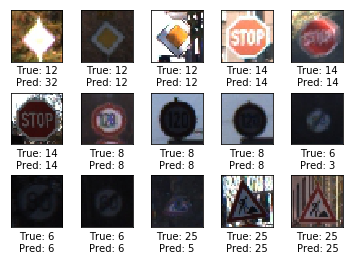

In [8]:
show_samples_with_predictions(X_test, y_test, preds)

In [9]:
def show_samples_with_probabilities(images, cls_true, cls_probs):
    """Show an image with its true class and class probabilities"""
    n = len(cls_true)
    # Create figure with 3xn sub-plots.
    fig, axes = plt.subplots(n, 2, figsize = (12,n*3))
    #fig.subplots_adjust(hspace=0.1, wspace=0.5)

    for j  in range(n):
        # Plot image.
        axes[j,0].imshow(images[j])
        axes[j,0].set_xticks([])        
        axes[j,0].set_yticks([])        
        axes[j,0].set_xlabel("True: {}".format(cls_true[j]))

        # Show class probabilities.
        labels = np.argsort(cls_probs[j])
        top5 = labels[-5:]
        axes[j,1].bar(left = range(5),height = cls_probs[j,top5])
        axes[j,1].set_xticks(range(5))
        axes[j,1].set_xticklabels(list(map(str,top5)))


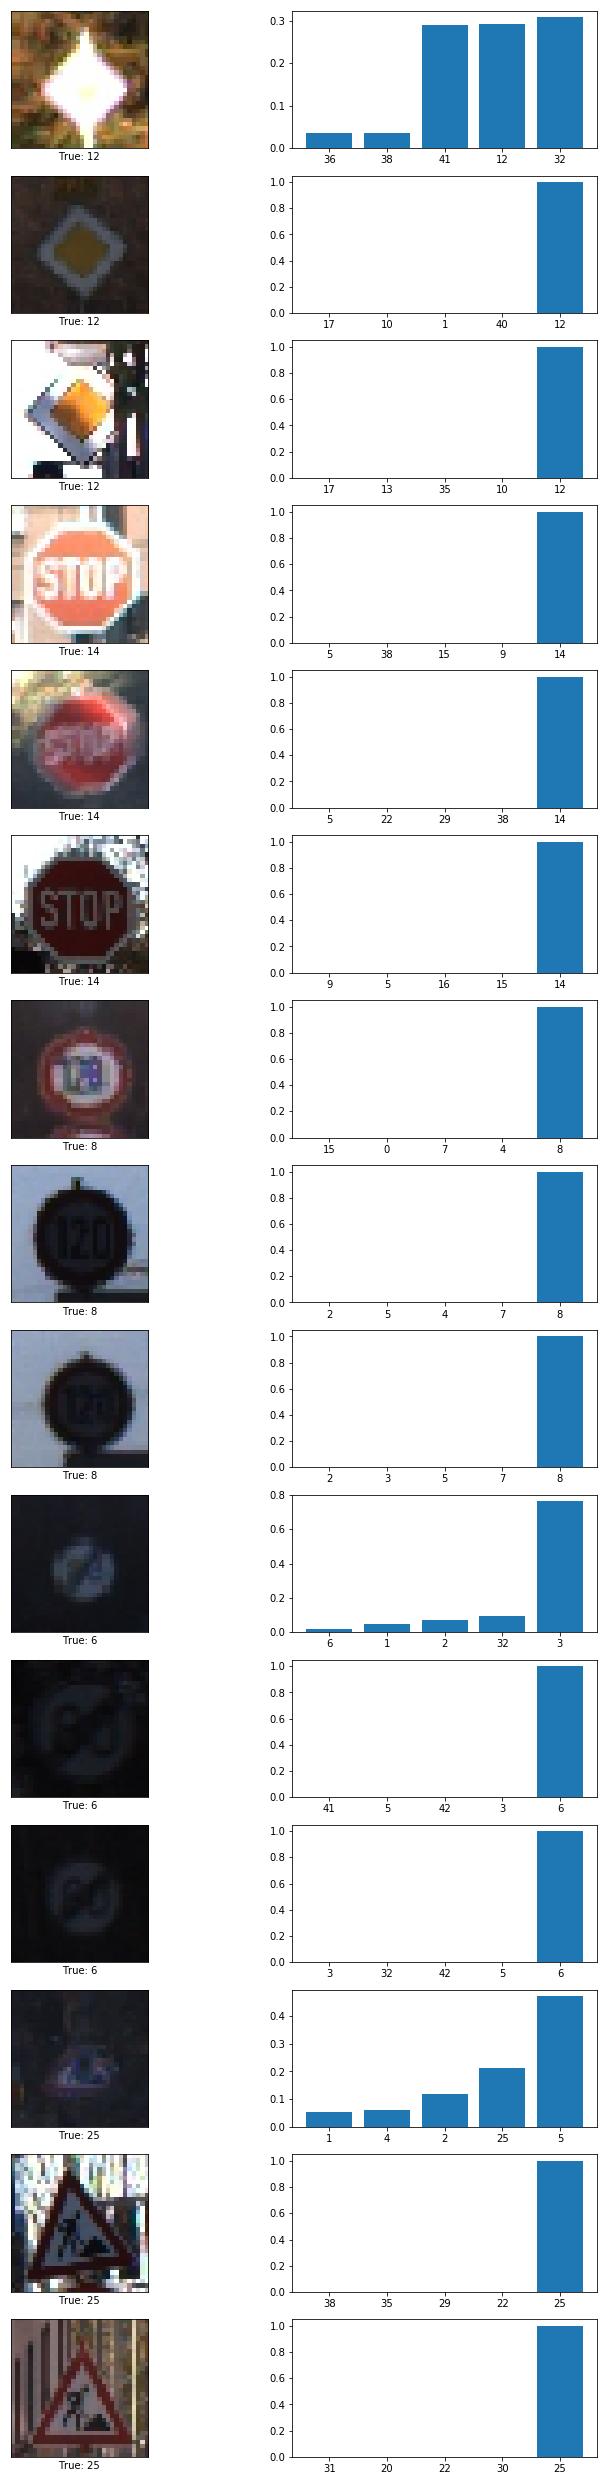

In [10]:
show_samples_with_probabilities(X_test, y_test, probs)

## Performance Measures

In [11]:
def print_confusion_matrix(cls_true, cls_pred, print_matrix = False, normalize = True):
    num_classes = 43
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # Print the confusion matrix as text.
    if print_matrix:
        print(cm)
        
    plt.rcParams['figure.figsize'] = 10, 10
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

In [12]:
test_files = get_files_path(TEST_DIR)
X_test, y_test = load_data(test_files)

100%|████████████████████████████████████| 12630/12630 [03:44<00:00, 56.38it/s]


In [13]:
def get_predictions(pred_op, X_, splits = 20):
    k = int(len(X_)/splits)
    prev = 0
    predictions = []
    for i in range(1, splits + 1):
        if i == splits:
            predictions += list(pred_op.eval(feed_dict={X: X_[prev:]}))
        else:
            predictions += list(pred_op.eval(feed_dict={X: X_[prev:i*k]}))
            prev = i*k
    return predictions

In [14]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(SAVER_FILE + '.meta')
    saver.restore(sess, SAVER_FILE)
    
    graph = tf.get_default_graph()
    #Now, access the op that you want to run. 
    X = graph.get_tensor_by_name("X:0")
    pred = graph.get_tensor_by_name("Prediction:0")
    #preds = sess.run(pred, feed_dict = {X: X_test})
    preds = get_predictions(pred, X_test)

In [17]:
print('Accuracy on test set:',accuracy_score(y_test, preds))

Accuracy on test set: 0.949802058591


Normalized confusion matrix


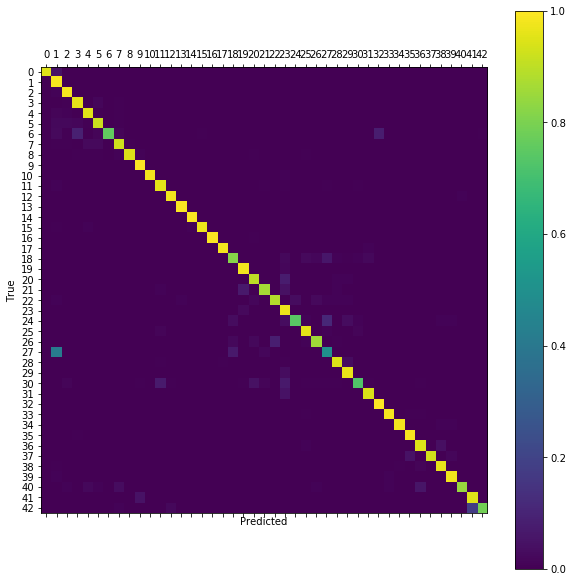

In [16]:
print_confusion_matrix(y_test, preds)